In [15]:
#export
import io, sys, warnings, time, k1lib, os
from contextlib import contextmanager
from functools import partial
try: import rdkit; hasRdkit = True
except: hasRdkit = False
try: import matplotlib.pyplot as plt
except: pass
__all__ = ["captureStdout", "capturePlt", "ignoreWarnings", "timer", "attrContext"]

In [2]:
#export
@contextmanager
def captureStdout(out=True, c=False) -> k1lib.Wrapper:
    """Captures every print() statement. Taken from https://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call.
Example::

    with k1lib.captureStdout() as outer:
        print("something")
        with k1lib.captureStdout() as inner:
            print("inside inner")
        print("else")
    # prints "['something', 'else']"
    print(outer.value)
    # prints "['inside inner']"
    print(inner.value)

Note that internally, this replaces :data:`sys.stdout` as :class:`io.StringIO`, so
might not work property if you have fancy :class:`bytes` stuff going on. Also,
carriage return (``\\r``) will erase the line, so multi-line overlaps might not
show up correctly.

If you wish to still print stuff out, you can do something
like this::

    with k1.captureStdout() as out:
        print("abc") # gets captured
        out.print("def") # not captured, will actually print out
        # you can also access the stream like this
        print("something", file=out.old)

Also, by default, this won't work if you're trying to capture C
library's output, because they write to stdout directly, instead of
going through Python's mechanism. You can capture it down at the C
level by doing this::

    with captureStdout() as out1, captureStdout(c=True) as out2:
        os.system("ls") # gets captured by out2, but not out1
        print("abc")    # gets captured by out1, but not out2

It's a little bit hard to actually integrate C mode and non-C mode
together, so for the time being, you gotta have 2 context managers
if you want to capture absolutely everything, C or not.

:param out: if True, captures stdout, else captures stderr
:param c: whether to capture at the C/C++ level or not"""
    if c is True:
        import wurlitzer; w = k1lib.Wrapper("")
        try:
            with wurlitzer.pipes() as (_out, _err): yield w
        except BrokenPipeError: pass
        finally: w.value = _out.read().split("\n") if out else _err.read().split("\n")
    else:
        if out: _stdout = sys.stdout; sys.stdout = _stringio = io.StringIO()
        else:   _stdout = sys.stderr; sys.stderr = _stringio = io.StringIO()
        w = k1lib.Wrapper([])
        w.print = partial(print, file=_stdout)
        w.old = _stdout
        try: yield w
        finally:
            w.value = [l.split("\r")[-1] for l in _stringio.getvalue().split("\n")]
            if out: sys.stdout = _stdout
            else:   sys.stderr = _stdout

In [3]:
with captureStdout() as testCapture:
    with captureStdout() as outer:
        print("something")
        with captureStdout() as inner:
            print("inside inner")
        print("else")
    print(outer.value); print(inner.value)
assert testCapture.value[0] == "['something', 'else', '']"
assert testCapture.value[1] == "['inside inner', '']"
with captureStdout() as outer:
    with captureStdout() as inner:
        print("abc") # gets captured
        inner.print("def") # not captured, will actually print out
assert inner() == ["abc", ""]; assert outer() == ["def", ""]
with captureStdout() as out1, captureStdout(c=True) as out2: os.system("ls"); print("abc")
assert out1() == ["abc", ""]; assert len(out2()) > 10

In [4]:
#export
@contextmanager
def capturePlt():
    """Tries to capture matplotlib plot.
Example::

    x = np.linspace(-2, 2)
    with k1.capturePlt() as fig:
        plt.plot(x, x**2)
        plt.show()

    capturedImage = fig() # reference it here

This is a convenience function to deal with libraries that call ``plt.show()``
and doesn't let us intercept at the middle to generate an image."""
    try:
        ans = k1lib.Wrapper(None)
        with k1lib._settings.monkey.context(capturePlt=True):
            yield ans
        ans.value = plt._k1_capturedImg()
    finally: pass

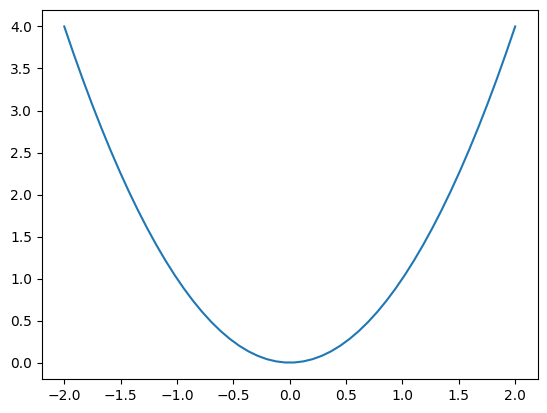

In [16]:
import numpy as np
k1lib.cli.init.patchNumpy()
x = np.linspace(-2, 2)
with capturePlt() as fig: plt.plot(x, x**2); plt.show()

In [23]:
import PIL; assert type(fig()) == PIL.Image.Image

In [4]:
#export
@contextmanager
def ignoreWarnings():
    """Context manager to ignore every warning.
Example::

    import warnings
    with k1lib.ignoreWarnings():
        warnings.warn("some random stuff") # will not show anything"""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        warnings.filterwarnings('ignore')
        if hasRdkit: rdkit.RDLogger.DisableLog('rdApp.*')
        yield
    if hasRdkit: rdkit.RDLogger.EnableLog('rdApp.*')

In [5]:
with ignoreWarnings(): warnings.warn("a")

In [6]:
#export
@contextmanager
def timer():
    """Times generic code.
Example::

    with k1lib.timer() as t:
        time.sleep(1.1)
    # prints out float close to 1.1
    print(t())

The with- statement will actually return a :class:`~k1lib.Wrapper` with value
None. The correct time will be deposited into it after the code block ends."""
    w = k1lib.Wrapper(None)
    beginTime = time.time()
    try: yield w
    finally: w.value = time.time() - beginTime

In [7]:
with timer() as t: time.sleep(1.1)
assert 1.0 < t() < 1.2

In [8]:
#export
@contextmanager
def attrContext(var, **kwargs):
    """Temporarily sets variable's attribute to something else.
Example::

    class A: pass
    a = A()
    a.b = 3
    print(a.b) # prints "3"
    with k1lib.attrContext(a, b=4, c=5):
        print(a.b, a.c) # prints "4 5"
    print(a.b, a.c) # prints "3 None"
"""
    oldValues = dict()
    for k, v in kwargs.items():
        oldValues[k] = getattr(var, k, None)
        setattr(var, k, v)
    try: yield
    finally:
        for k, v in oldValues.items():
            setattr(var, k, v)

In [9]:
class A: pass
a = A(); a.b = 3
with captureStdout() as out: print(a.b)
assert out() == ["3", ""]
with attrContext(a, b=4, c=5):
    with captureStdout() as out: print(a.b, a.c)
    assert out() == ["4 5", ""]
with captureStdout() as out: print(a.b, a.c) # prints ""
assert out() == ["3 None", ""]

In [26]:
!../export.py _context

Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.3
Uninstalling k1lib-1.3:
  Successfully uninstalled k1lib-1.3
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing 